In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
# from google.colab import drive

# Mount Google Drive
# drive.mount("/content/drive")

# Add utility folder to the python path
utils_path = "../utils"
sys.path.append(utils_path)

# Import custom reporting function
import eda_utils

# 1. Introduction and Setup Section

### Telco Customer Churn: Exploratory Data Analysis

The primary objective of this analysis is to explore the Telco Customer Churn dataset to identify the key factors and patterns associated with customer churn. The insights from this EDA can inform the development of targeted retention strategies and serve as a foundation for building a predictive churn model.

The dataset was obtained from Kaggle and contains 7,043 customer records with 21 attributes detailing their services, account information, and churn status. [https://www.kaggle.com/datasets/blastchar/telco-customer-churn].

Content

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents.


### Data Dictionary

Customer & Demographic Information
- customerID: A unique identifier for each customer.
- gender: The customer's gender (Male, Female).
- SeniorCitizen: Indicates if the customer is a senior citizen (1 for Yes, 0 for No).
- Partner: Indicates if the customer has a partner (Yes, No).
- Dependents: Indicates if the customer has dependents (Yes, No).

Customer Account Information
- tenure: The number of months the customer has been with the company.
- Contract: The customer's contract term (Month-to-month, One year, Two year).
- PaperlessBilling: Indicates if the customer uses paperless billing (Yes, No).
- PaymentMethod: The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)).
- MonthlyCharges: The amount charged to the customer monthly (numeric).
- TotalCharges: The total amount charged to the customer over their entire tenure (numeric, requires cleaning).

Service Information
- PhoneService: Indicates if the customer has phone service (Yes, No).
- MultipleLines: Indicates if the customer has multiple phone lines (Yes, No, No phone service).
- InternetService: The customer's internet service provider (DSL, Fiber optic, No).
- OnlineSecurity: Indicates if the customer has the online security service (Yes, No, No internet service).
- OnlineBackup: Indicates if the customer has the online backup service (Yes, No, No internet service).
- DeviceProtection: Indicates if the customer has the device protection service (Yes, No, No internet service).
- TechSupport: Indicates if the customer has the tech support service (Yes, No, No internet service).
- StreamingTV: Indicates if the customer has the TV streaming service (Yes, No, No internet service).
- StreamingMovies: Indicates if the customer has the movie streaming service (Yes, No, No internet service).

Target Variable
- Churn: The target variable for this analysis. Indicates if the customer churned (left the company) within the last month (Yes, No).

In [3]:
# --- 2. LOAD DATA ---
# Define the file path
file_path = "./data/telco_churn.csv"

# Load the dataset
df = pd.read_csv(file_path)

In [4]:
# --- 3. INITIAL EXPLORATION ---
# Using our eda utility function
eda_utils.initial_report(df)

--- Initial Data Report ---

--- Shape ---
Rows: 7043, Columns: 21

--- Data Types & Non-Null Counts ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null

- No Duplicates: Number of duplicate rows:0. Looks clean.
- No obvious Missing Values: Missing Values (%) is empty.
- Unique ID: customerID has 7043 unique values, matching the number of rows. This confirms is a unique identifier and can likely drop for analysis and modelling purposes, but keep for reference.

### Preliminary take-aways

1. TotalCharges appears to be a string (object).
    - df.info() shows TotalCharges has Dtyper: object.
    - df.describe(). TotalCharges is missing from the numerical summary but present in the categorical summary. This should be a continuous variable.
    - Why is it an object when the head shows numbers like 1889.5? This almost always means there are some non-numeric values hidden somewhere hidden in the column.A common culprit is an empty space (' ') for customers who have zero tenure (e.g a brand new customer has monthly charges but no total charges yet). Our "No Missing Values" was a red herring; these spaces are not registered as Nan but are functionally missing data.

2. Inconsistent SeniorCitizen column.
    - df.info(), SeniorCitizen is an int64 (0 or 1).
    - Every other binary categorical column (Partner, Dependents, Churn, etc) is an object with'Yes/No' values.

3. Rich caegorical features
    - Categorical summary shows many columns with 2, 3, or 4 unique values.
    - These are the features we will use to slice and dice the data to understand churn.We can start forming hypotheses.
        - Does Contract: Month-to-month lead to more churn than One year? The top value is Month-to-month which seems plausible.
        - Does PaymentMethod: Electronic check have a diferent churn rate.

## 2. Data Cleaning and Preparation

Based on the findings from our initial report, we need to perform two key cleaning tasks before we can begin our analysis:

1.  **Fix `TotalCharges`:** The `TotalCharges` column is currently an `object` type due to hidden non-numeric values. We must convert it to a numeric type to use it in calculations.
2.  **Standardize `SeniorCitizen`:** This column is a numeric `int64` (0/1) while other binary columns are `object` ('Yes'/'No'). We will standardize it to 'No'/'Yes' for consistency in our analysis and visualizations.

Let's address `TotalCharges` first.

### Task A: Fix **TotalCharges**

In [5]:
# --- Task A.1: Convert TotalCharges to numeric ---
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# --- Task A.2: Check for newly created missing values ---
print(f"Number of null values in TotalCharges after conversion: {df['TotalCharges'].isnull().sum()}")


# --- Task A.3: Investigate the rows with null TotalCharges ---
print("\nDisplaying rows where TotalCharges is null:")
df[df['TotalCharges'].isnull()]

Number of null values in TotalCharges after conversion: 11

Displaying rows where TotalCharges is null:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


**Observation**
The conversion process created 11 'NaN' values. On inspection, we can confirm the hypothesis **all 11 customers have a 'tenure' of 0.** So these are brand new customers who have not yet accumulated any 'total' charges.

**Decision**
We have two options: drop these 11 rows or impute the missing values. Since they are legitamite new customers, dropping them would be a loss of information.
The most logical value to impute is **0**, as a customer with zero months of tenure should have zero total charges.



In [6]:
# --- Task A.4: Impute the missing values with 0 ---
# Going to use boolean logic as there seems to be a problem in the copy state of notebook.
df.loc[df['TotalCharges'].isnull(), 'TotalCharges'] = 0
print(df['TotalCharges'].dtype)

# --- Task A.5: Verify the fix ---
# Check the null count to ensure succesful implementation.
print(f"Number of null values in TotalCharges after imputation: {df['TotalCharges'].isnull().sum()}")

# --- Task A.3: Confirm data type of the column after modifying.
print(f"\nNew data type of TotalCharges: {df['TotalCharges'].dtype}")

float64
Number of null values in TotalCharges after imputation: 0

New data type of TotalCharges: float64


### Task B: Standardise **SeniorCitizen**

Now that 'TotalCharges' is fixed, let's standardise the 'SeniorCitizen' column to match the 'Yes/No' format of the other categorical variables.

In [7]:
# --- Task B: Convert SeniorCitizen from 0/1 to 'No'/'Yes' ---
# This idempotent check ensures the mapping only happens on the original integer data.
if df['SeniorCitizen'].dtype == 'int64':
    df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [8]:
# --- Veification Step ---
print("---Verification of cleaning ---")
print(f"TotalCharges nulls: {df['TotalCharges'].isnull().sum()}")
print(f"TotalCharges dtype: {df['TotalCharges'].dtype}\n")

print("SeniorCitizen value counts:")
print(df['SeniorCitizen'].value_counts())

---Verification of cleaning ---
TotalCharges nulls: 0
TotalCharges dtype: float64

SeniorCitizen value counts:
SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64


#### Save copy of cleaned dataframe for our ml notebook

In [ ]:
# --- Save the clean, prepared DataFrame to a new file ---
# clean_file_path = '/content/drive/MyDrive/Data_Analysis_Portfolio/project_telco_churn/data/telco_churn_cleaned.csv'
# df.to_csv(clean_file_path, index=False)
# print(f"Cleaned data successfully saved to: {clean_file_path}")

Cleaned data successfully saved to: /content/drive/MyDrive/Data_Analysis_Portfolio/project_telco_churn/data/telco_churn_cleaned.csv


## 3. Exploratory Data analysis

With a clean dataset, we can now begin our exploration. The primary goal is to understand the characteristics of customers who churn versus those who do not. We will start by analyzing our target variable, `Churn`, and then move on to explore its relationship with other features.

### 3.1 Analyzing the Target Variable: Churn

First, let's understand the overall distribution of churn in the dataset. How many customers have churned? What is the overall churn rate?

Churn Counts:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


Churn Percentages:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


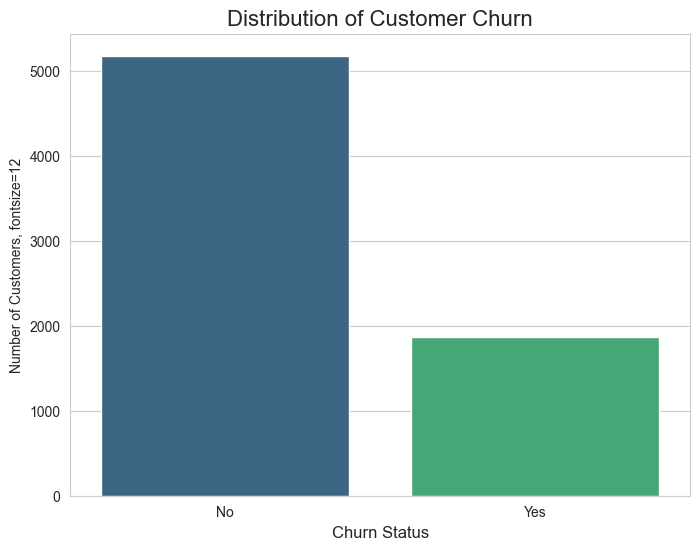

In [9]:
# --- Calculate the counts and percentages of churn ---

# Get the absolute counts
churn_counts = df['Churn'].value_counts()
print("Churn Counts:")
print(churn_counts)
print("\n")

# Calculate the percentages
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("Churn Percentages:")
print(churn_percentage)

# --- Visualise the distribution ---

# Set the style for the plot
sns.set_style("whitegrid")

# Create the countplot
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df, palette='viridis', hue='Churn', legend=False)

# Add a title and labels for clarity
plt.title('Distribution of Customer Churn', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Number of Customers, fontsize=12')

# Show plot
plt.show()

**Observations:**
*   Out of 7,043 customers, **1,869** have churned, while **5,174** have not.
*   This represents an overall churn rate of approximately **26.5%**.
*   The dataset is **imbalanced**, with about three times as many non-churners as churners. This is a common scenario in churn analysis. While this is important to know for future machine learning modeling (e.g., using techniques like SMOTE or adjusting class weights), for our EDA, it simply establishes our baseline. The central question of our analysis is: **what makes this 26.5% of customers different from the other 73.5%?**

### 3.2 Bivariate Analysis: Exploring Relationships with Churn

Now that we understand the overall churn rate, we will investigate how different customer attributes relate to churn. We will tackle this by looking at two types of relationships:

*   **Categorical Features vs. Churn:** How do churn rates differ across groups like gender, contract type, or internet service?
*   **Numerical Features vs. Churn:** Do customers who churn have a different average tenure or monthly charge compared to those who stay?

Let's start with the categorical features. For each categorical feature, we want to answer the question: "Is the churn rate significantly different for different categories within this feature?" Let's calculate the churn rate for each category and then visualize it.

#### Demographics: Gender and Senior Citizen Status

We'll begin with the basic demographic information. Does being male or female, or being a senior citizen, affect the likelihood of churning?

Churn Rate by Gender:
Churn          No        Yes
gender                      
Female  73.079128  26.920872
Male    73.839662  26.160338




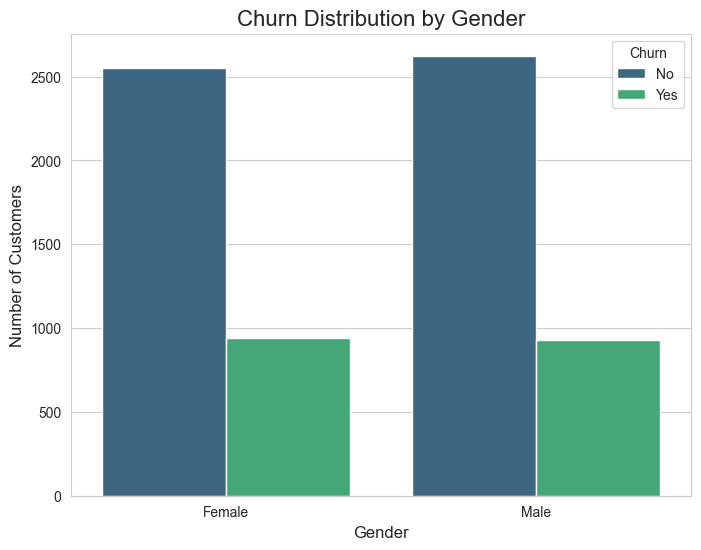

In [10]:
# --- Analyse Churn Rate by Gender ---
print('Churn Rate by Gender:')

# Using crosstab instead of groupby for raw counts
# normalize='index' is the key to getting the percentage rate across each row (gender).
gender_churn_rate = pd.crosstab(df['gender'], df['Churn'], normalize='index') * 100
print(gender_churn_rate)
print("\n")

# --- Visualise Churn by Gender ---
plt.figure(figsize=(8, 6))
# The 'hue' parameter is what separates teh bars by Churn status
ax = sns.countplot(x='gender', hue='Churn', data=df, palette='viridis')

plt.title('Churn Distribution by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn', loc='upper right')


**Observation (Gender):**
The churn rates for `Male` (26.16%) and `Female` (26.92%) customers are nearly identical. This strongly suggests that **gender is not a significant driver of churn** in this dataset. We can likely de-prioritize this feature in our search for key factors.

Churn Rate by Senior Citizen Status:
Churn                 No        Yes
SeniorCitizen                      
No             76.393832  23.606168
Yes            58.318739  41.681261




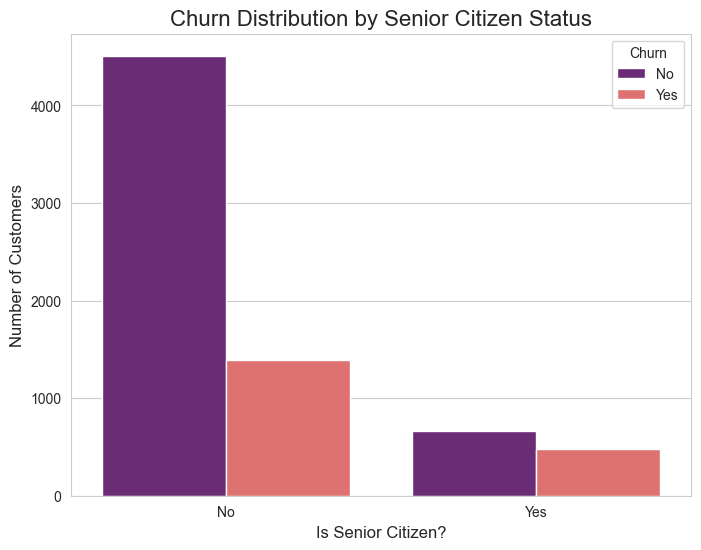

In [11]:
# --- Analyze Churn Rate by Senior Citizen Status ---

print("Churn Rate by Senior Citizen Status:")
senior_churn_rate = pd.crosstab(df['SeniorCitizen'], df['Churn'], normalize='index') * 100
print(senior_churn_rate)
print("\n")

# --- Visualize Churn by Senior Citizen Status ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='SeniorCitizen', hue='Churn', data=df, palette='magma')

plt.title('Churn Distribution by Senior Citizen Status', fontsize=16)
plt.xlabel('Is Senior Citizen?', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn')
plt.show()

**Observation (Senior Citizen):**
Here we see a dramatic difference. The churn rate for Senior Citizens is **41.68%**, which is substantially higher than the **23.61%** churn rate for non-senior citizens.

**This is our first major finding!** Senior citizens represent a high-risk group for churn. Any retention strategy should likely have a specific focus on this demographic.

#### Numerical Features: Tenure, Monthly, and Total Charges

Now we'll investigate if the numerical aspects of a customer's account—how long they've been a customer and how much they pay—are different for those who churn. A powerful way to visualize this is by comparing the distributions of these features for churners and non-churners using box plots. Box plots allow us to quickly compare the median, spread (interquartile range), and identify potential outliers for each group.

Let's start with `tenure`.

Descriptive Statistics for Tenure by Churn Status:
        count       mean        std  min   25%   50%   75%   max
Churn                                                           
No     5174.0  37.569965  24.113777  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.979133  19.531123  1.0   2.0  10.0  29.0  72.0




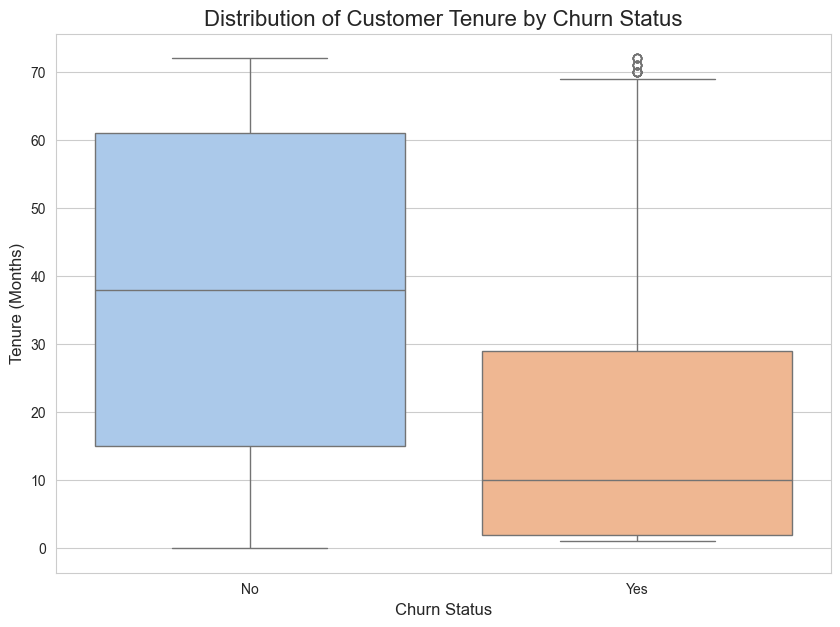

In [12]:
# --- Analyze Tenure vs. Churn ---

# First, let's look at the descriptive statistics for tenure grouped by churn status.
print("Descriptive Statistics for Tenure by Churn Status:")
print(df.groupby('Churn')['tenure'].describe())
print("\n")

# --- Visualize Tenure vs. Churn ---
plt.figure(figsize=(10, 7))
sns.boxplot(x='Churn', y='tenure', hue ='Churn', data=df, palette='pastel')

plt.title('Distribution of Customer Tenure by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Tenure (Months)', fontsize=12)
plt.show()

**Observation (Tenure):**
The box plot and descriptive statistics reveal a very strong pattern:

*   **Customers who churn have a significantly lower tenure.** The median tenure for churners is only **10 months**, compared to **38 months** for customers who stay.
*   The entire box (the middle 50% of customers) for churners lies below the median for non-churners. This indicates a high risk of churn in the early stages of a customer's lifecycle.

**Insight:** This is another major finding. **Customer loyalty increases dramatically with time.** Retention efforts should be heavily focused on new customers, particularly within their first year.

Now let's apply this same analytical pattern to `MonthlyCharges`. Our hypothesis might be that customers who pay more are more likely to churn. Let's see if the data supports this.



Descriptive Statistics for MonthlyCharges by Churn Status:
        count       mean        std    min    25%     50%   75%     max
Churn                                                                  
No     5174.0  61.265124  31.092648  18.25  25.10  64.425  88.4  118.75
Yes    1869.0  74.441332  24.666053  18.85  56.15  79.650  94.2  118.35




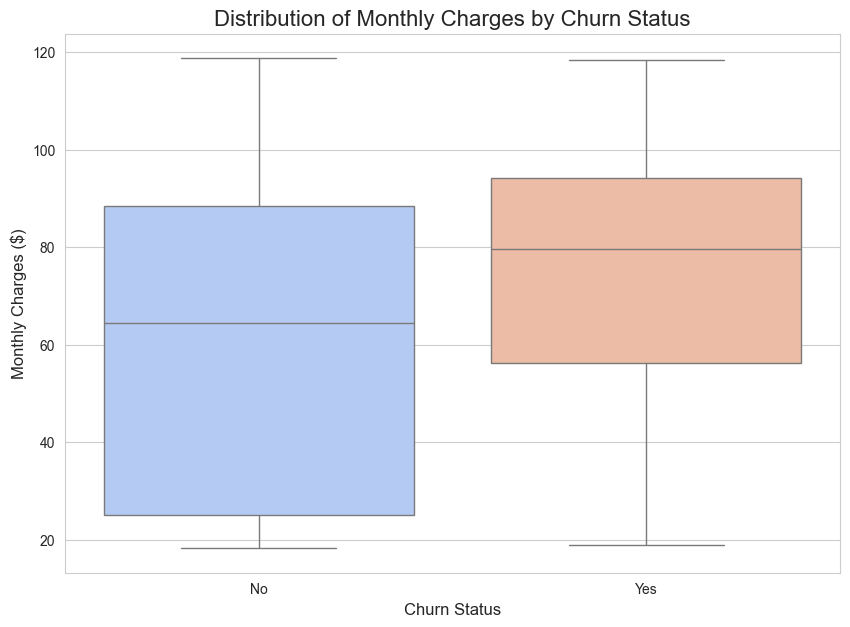

In [13]:
# --- Analyze MonthlyCharges vs. Churn ---

print("Descriptive Statistics for MonthlyCharges by Churn Status:")
print(df.groupby('Churn')['MonthlyCharges'].describe())
print("\n")

# --- Visualize MonthlyCharges vs. Churn ---
plt.figure(figsize=(10, 7))
sns.boxplot(x='Churn', y='MonthlyCharges', hue='Churn', data=df, palette='coolwarm')

plt.title('Distribution of Monthly Charges by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Monthly Charges ($)', fontsize=12)
plt.show()

**Observation (Monthly Charges):**
The data confirms our hypothesis. Customers who churn tend to have higher monthly charges.

*   The median monthly charge for churners is 79.65, which is notably higher than the median of 64.40 for non-churners.
*   The distribution for churners is also more skewed towards higher costs, with a tighter interquartile range at the top end.

**Insight:** This suggests price sensitivity is a key factor. Customers on more expensive plans may be more likely to shop for better deals or feel they are not getting enough value for their money. This is especially interesting when combined with our `SeniorCitizen` finding, as they may be on fixed incomes.

Before moving on to the service-related features, it's important to complete our analysis of the core numerical columns. Let's investigate the relationship between `TotalCharges` and customer churn.

Our initial hypothesis might be that customers with lower total charges would churn more (since we know they have lower tenure). Let's verify this with a visualization.

Descriptive Statistics for TotalCharges by Churn Status:
        count         mean          std    min    25%       50%      75%  \
Churn                                                                      
No     5174.0  2549.911442  2329.954215   0.00  572.9  1679.525  4262.85   
Yes    1869.0  1531.796094  1890.822994  18.85  134.5   703.550  2331.30   

           max  
Churn           
No     8672.45  
Yes    8684.80  




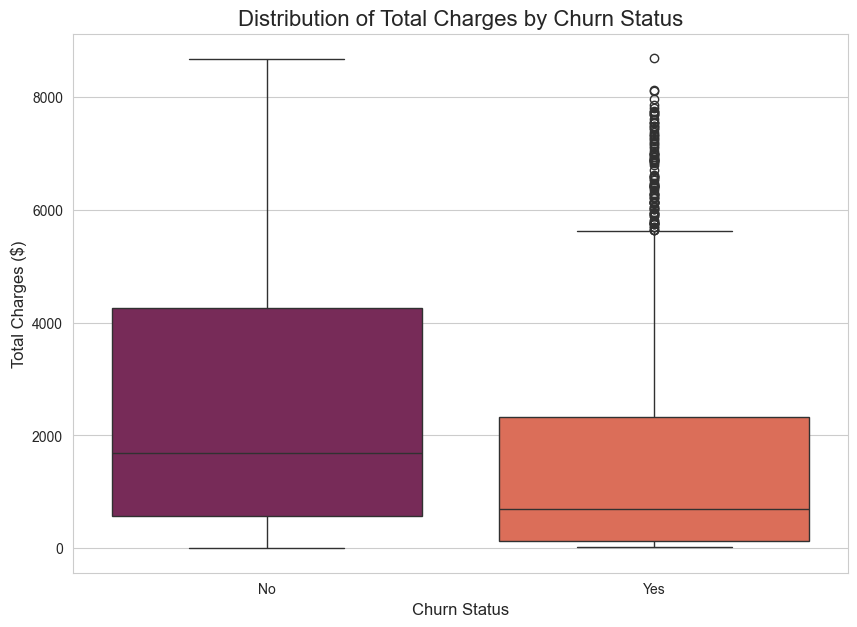

In [14]:
# --- Analyze TotalCharges vs. Churn ---

print("Descriptive Statistics for TotalCharges by Churn Status:")
print(df.groupby('Churn')['TotalCharges'].describe())
print("\n")

# --- Visualize TotalCharges vs. Churn ---
plt.figure(figsize=(10, 7))
sns.boxplot(x='Churn', y='TotalCharges', hue = 'Churn', data=df, palette='rocket')

plt.title('Distribution of Total Charges by Churn Status', fontsize=16)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Total Charges ($)', fontsize=12)
plt.show()

1. Distribution Shape: The box plot for "Yes" (churners) shows a very large number of churners are clustered in the low TotalCharges range. The plot for "No" (non-churners) shows that loyal customers exist across a wide spectrum of total spending.

The describe() table confirms this: The 75th percentile for churners 2331 is only slightly above the median for non-churners 2242. This means 75% of all customers who left had spent less than the typical loyal customer.

2. The Insight (What the data means):
At first glance, one might think, "Customers who spend less are more likely to leave." But this is a classic case of correlation not equaling causation. We must combine this finding with our previous analysis of tenure.

We know that TotalCharges is highly dependent on tenure (Total Charges ≈ Tenure × Monthly Charges).
Therefore, the most powerful insight here is:
This plot doesn't show that low spending causes churn. It powerfully visualizes the symptom of early churn.
Customers are leaving so early in their lifecycle (tenure is low) that they never get a chance to accumulate high TotalCharges. This finding strongly reinforces our earlier conclusion: tenure is the dominant factor. The first few months of a customer's journey are the most critical "danger zone" for churn.

### Visualizing the Raw Distribution of Total Charges

To get a clearer picture of the `TotalCharges` distribution beyond the summary statistics, we can plot histograms or Kernel Density Estimates (KDE) for both churners and non-churners.

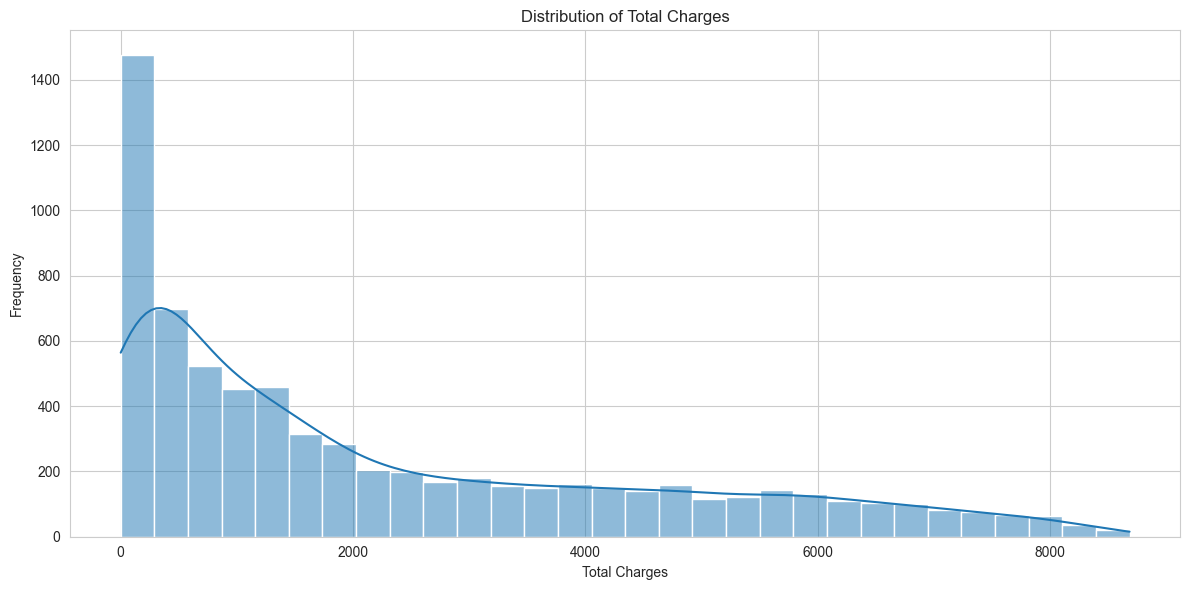

In [15]:
# Plot distribution of Total Charges

plt.figure(figsize=(12, 6))
sns.histplot(df['TotalCharges'], bins=30, kde=True)
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()

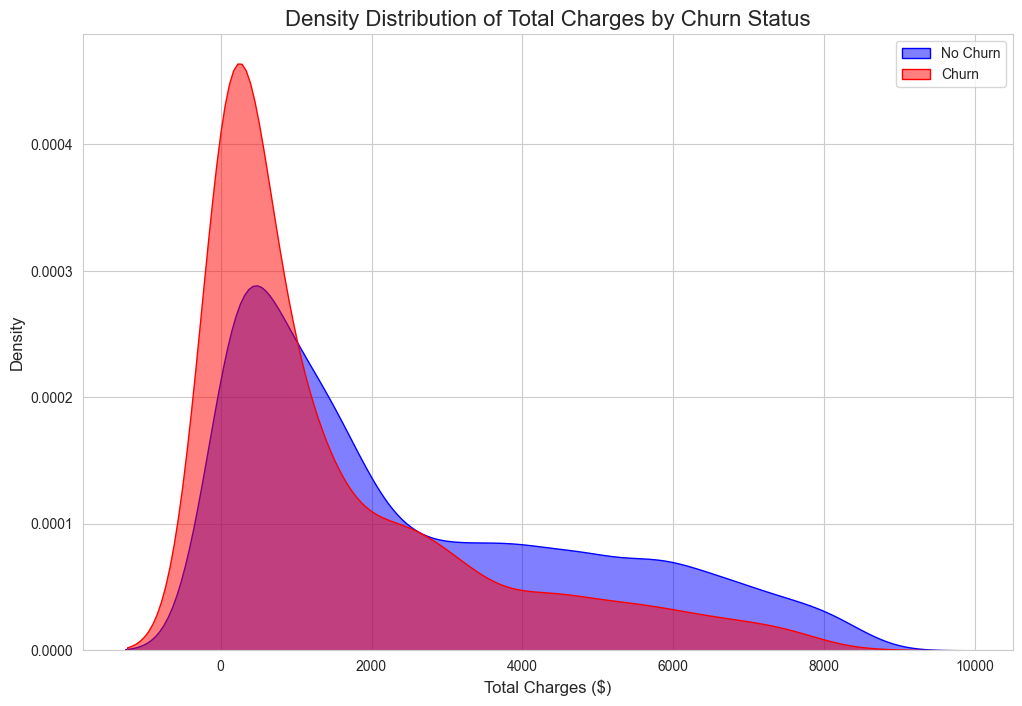

In [16]:
plt.figure(figsize=(12, 8))

# Plot KDE for customers who did not churn
sns.kdeplot(df[df['Churn'] == 'No']['TotalCharges'], label='No Churn', color='blue', fill=True, alpha=0.5)

# Plot KDE for customers who did churn
sns.kdeplot(df[df['Churn'] == 'Yes']['TotalCharges'], label='Churn', color='red', fill=True, alpha=0.5)

plt.title('Density Distribution of Total Charges by Churn Status', fontsize=16)
plt.xlabel('Total Charges ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

- The "Churn" (Red) Curve: This curve is extremely high and sharply peaked very close to zero, and then it rapidly falls off. There's a very long, but very flat, tail extending to the right.
- The "No Churn" (Blue) Curve: This curve is much flatter and more spread out. It has a small peak near zero (representing new customers who haven't churned yet) but its main body is distributed much more evenly across the entire range of total charges, with another peak at the very high end (representing very long-term, loyal customers).
- The Overlap: The most significant "battleground" where the two curves interact is in the low-to-mid range of total charges. After a certain point (e.g., ~$3000), the red "Churn" curve is almost completely flat at zero, meaning virtually no customers with very high total charges are churning.

The Insight This Adds:

This visualization tells the story more comprehensively than the box plot did. It adds two key insights:

Confirmation of the early danger zone: The massive red peak near zero is a stark confirmation that the overwhelming majority of churn events happen to customers who have paid very little in total—because they are new. It visually represents the early loss of customers.

The escape velocity: The blue curve shows that if a customer's TotalCharges get high enough (meaning their tenure is long enough), they effectively reach an escape velocity where their probability of churning becomes almost zero. They are "locked in" as loyal customers. The business goal is to get as many customers as possible past that initial red peak and into the safer, flatter part of the blue curve.

### 3.3 Interim Summary of Findings

Before moving on to service-specific features, let's summarize the key characteristics we've identified that correlate with customer churn:

*   **Overall Churn Rate:** The baseline churn rate is **~26.5%**. Our goal is to find what factors push customers above or below this baseline.

*   **Key Predictive Factors Identified So Far:**
    *   **Tenure:** This appears to be the **strongest indicator** of churn. Customers who churn have a median tenure of only 10 months, compared to 38 for loyal customers. The risk is highest for new customers.
    *   **Monthly Charges:** Price sensitivity is a clear factor. Customers who churn have significantly higher median monthly charges ($79.65 vs. $64.40).
    *   **Senior Citizen Status:** This is a powerful demographic predictor. Senior citizens churn at a rate of **~42%**, far higher than their non-senior counterparts (~24%).

*   **Non-Predictive / Less Important Factors:**
    *   **Gender:** Has virtually no impact on churn.
    *   **Total Charges:** This is largely a reflection of `tenure`, making it a less direct or "pure" indicator. Low total charges are a *symptom* of early churn, not a cause.

Contract is arguably the most pertinent feature we've yet to analyze. The business has direct control over contract offerings, so any insights here are highly actionable.

For a categorical variable with a few levels (like Month-to-month, One year, Two year) versus a binary target (Churn), the best approach is a powerful two-step process:

1) Quantify the Churn Rate: Calculate the precise churn percentage for each contract type.

2) Visualize the Difference: Create a compelling chart that makes the difference immediately obvious to any viewer.


### 3.4 Service-Related Features: Contract Type

Now, let's analyze the most critical service-related feature: the customer's contract term. Intuitively, we would expect customers on shorter contracts to be more likely to churn. Let's see if the data supports this.

Churn Rate by Contract Type:
Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.730482  11.269518
Two year        97.168142   2.831858




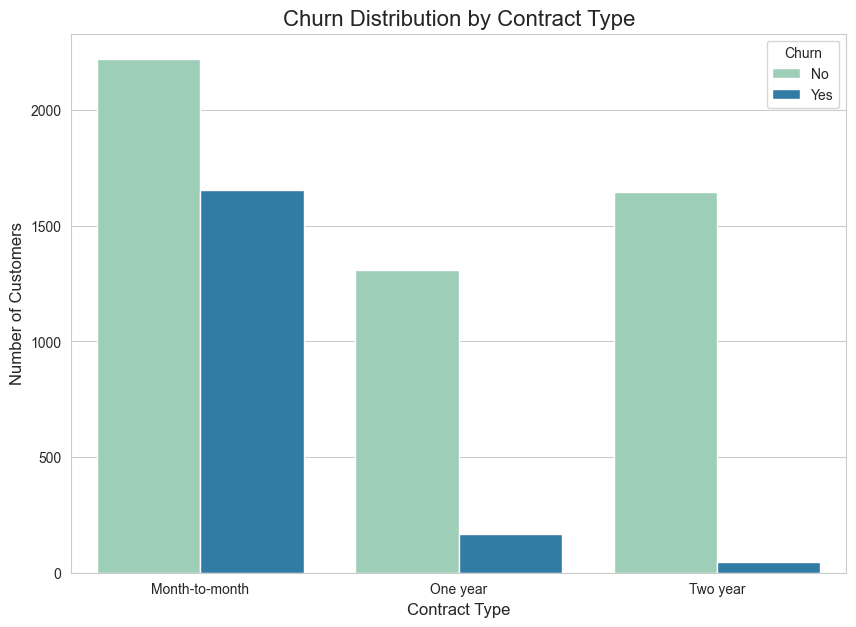

In [17]:
# --- 1. Quantify the Churn Rate by Contract Type ---

print("Churn Rate by Contract Type:")
# The crosstab with normalize='index' is the perfect tool for this.
# It gives us the proportion of Churn ('No'/'Yes') for each Contract type.
contract_churn_rate = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
print(contract_churn_rate)
print("\n")

# --- 2. Visualize the Distribution ---
plt.figure(figsize=(10, 7))
ax = sns.countplot(x='Contract', hue='Churn', data=df, palette='YlGnBu')

plt.title('Churn Distribution by Contract Type', fontsize=16)
plt.xlabel('Contract Type', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(title='Churn')
plt.show()

**Observation (Contract Type):**
The results are incredibly stark and confirm our hypothesis in the strongest possible terms.

*   **Month-to-Month:** Customers on a month-to-month contract churn at an astonishing rate of **42.7%**.
*   **One Year:** The rate drops dramatically to **11.3%** for customers on a one-year contract.
*   **Two Year:** The rate is almost negligible at just **2.8%** for customers on a two-year contract.

**Insight:** This is arguably the **single most important finding in the entire dataset.** The contract type is a massive predictor of customer loyalty. The business has a powerful incentive to create programs or offers that encourage customers to move from month-to-month plans to longer-term contracts. This single change could have a huge impact on reducing overall churn.

### 3.5 Analyzing Service-Related Features: A Dashboard Approach

Instead of analyzing each service-related feature individually, a more efficient method is to create a "dashboard" of visualizations. This allows us to compare the impact of multiple features at a glance and quickly identify which services are most correlated with customer churn.

We will create a grid of count plots for all key service features.

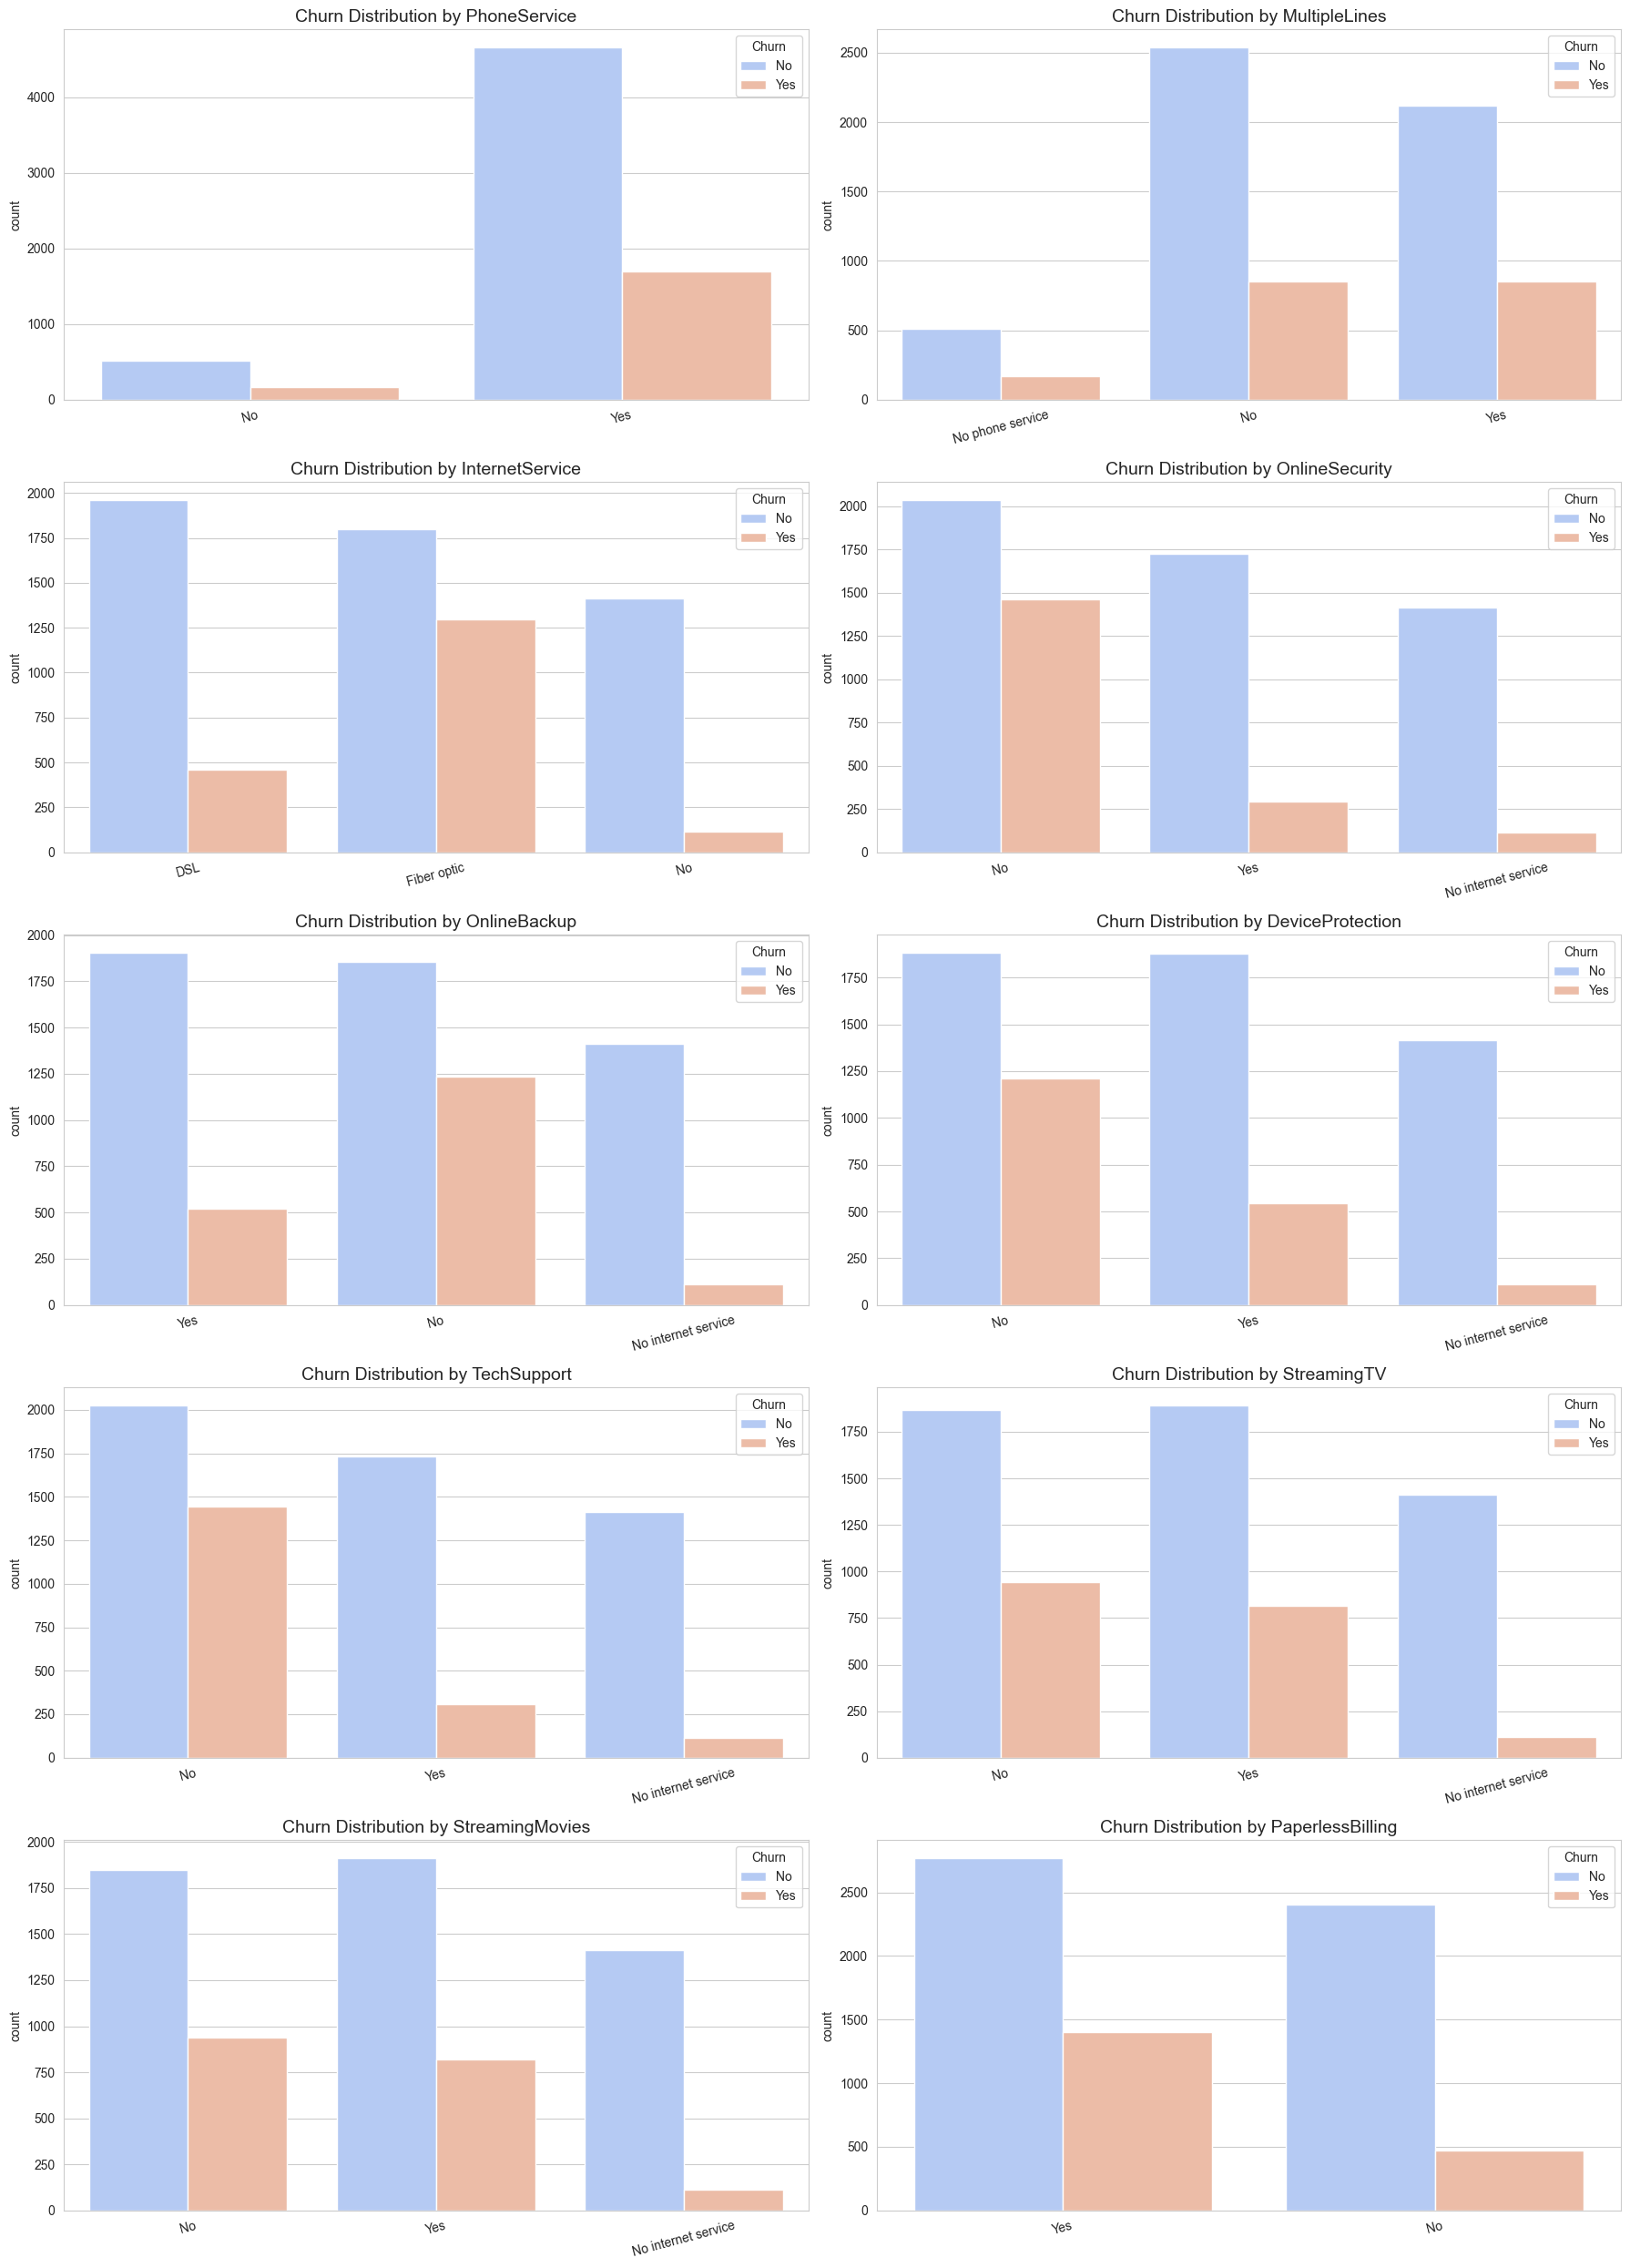

In [18]:
# --- Identify all service-related features ---
# Note: We've already analyzed gender, SeniorCitizen, Partner, Dependents.
# We'll focus on the services the company provides.
service_features = [
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'PaperlessBilling'
]

# --- Create the dashboard of subplots ---
# Set up the figure and axes for a 5x2 grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the features and create a countplot for each
for i, feature in enumerate(service_features):
    ax = axes[i] # Select the subplot
    sns.countplot(x=feature, hue='Churn', data=df, ax=ax, palette='coolwarm')
    ax.set_title(f'Churn Distribution by {feature}', fontsize=14)
    ax.set_xlabel('') # Clear x-axis label for cleaner look
    ax.tick_params(axis='x', rotation=15) # Rotate x-labels slightly for readability

# Adjust the layout to prevent titles/labels from overlapping
plt.tight_layout()

# If there's an odd number of plots, hide the last empty one
if len(service_features) < len(axes):
    for j in range(len(service_features), len(axes)):
        axes[j].set_visible(False)

plt.show()

**Dashboard Analysis & Key Insights:**

By examining all service features together, we can rapidly triage them into high-impact and low-impact categories.

*   **High-Impact Features (Strong Correlation with Churn):**
    *   **InternetService:** Just like `Contract`, this is a major factor. The churn rate for customers with **Fiber optic** service is dramatically higher than for those with **DSL**. This is a critical finding—the company's premium internet product is associated with higher churn. This could be due to price, reliability issues, or aggressive competitor marketing.
    *   **OnlineSecurity & TechSupport:** These two are nearly identical. Customers who do **not** have these services (`No`) churn at a much higher rate. This suggests that customers who feel their service is secure and well-supported are more likely to stay. These services provide significant value and "stickiness."

*   **Moderate-Impact Features:**
    *   **OnlineBackup & DeviceProtection:** Similar to the above, but the effect is less pronounced. Having these services is associated with lower churn, but not as strongly as `OnlineSecurity` or `TechSupport`.
    *   **PaperlessBilling:** Customers using paperless billing have a higher churn rate. This is an interesting and less obvious finding. It could be that this group is more tech-savvy and comfortable switching providers, or that paper bills serve as a more consistent "physical reminder" of the service.

*   **Low-Impact Features (Weak Correlation with Churn):**
    *   **PhoneService & MultipleLines:** Having phone service or multiple lines appears to have very little impact on the overall churn rate. The distributions are fairly similar for all categories.
    *   **StreamingTV & StreamingMovies:** While there's a slight difference, whether a customer streams content or not does not appear to be a major driver of their decision to leave.

**Conclusion from the Dashboard:**
This holistic view was highly effective. We can confidently say that the most important service-related factors are **Internet Service type**, and whether the customer subscribes to "protective" add-ons like **Online Security and Tech Support**.

**A Note on Feature Dependency:**

A key structural pattern revealed by the dashboard is the dependency between services. For features like `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies`, there is a large category of customers who have "No internet service".

This is not a churn driver itself, but rather a structural aspect of the data: **customers without internet cannot possibly subscribe to these internet-based add-ons.**

While not directly pertinent to our churn analysis right now, this is a critical observation for more advanced downstream tasks:

*   **For Predictive Modeling:** This multicollinearity means we wouldn't want to include *all* of these features in certain model types without careful consideration (e.g., regularization).
*   **For Business Strategy:** As you rightly noted, this hints at product bundling. It suggests the company has two major customer archetypes: "Phone-Only" customers and "Internet" customers. Any deep segmentation analysis would need to start by splitting the customer base along this line.

This observation is a great example of how EDA not only uncovers relationships with a target variable but also reveals the underlying structure of the data itself.

## 4. Conclusion & Recommendations: A Profile of the At-Risk Customer

This Exploratory Data Analysis of the Telco customer dataset has revealed several strong, actionable insights into the key drivers of customer churn. Based on the analysis, we can construct a clear profile of a customer who is at high risk of churning.

### Profile of an At-Risk Customer:

An at-risk customer is most likely to be:
1.  **On a Month-to-Month Contract:** This is the single strongest predictor of churn. These customers lack long-term commitment and are free to leave at any time.
2.  **A New Customer (Low Tenure):** The "danger zone" is heavily concentrated in the early months of the customer lifecycle.
3.  **Using Fiber Optic Internet Service:** While a premium product, it is associated with a significantly higher churn rate, pointing to potential issues with price, reliability, or competitor offerings.
4.  **Paying High Monthly Charges:** Price sensitivity is a clear factor, especially for customers on expensive plans.
5.  **A Senior Citizen:** This demographic churns at a substantially higher rate.
6.  **Lacking "Protective" Add-on Services:** Customers without `OnlineSecurity` and `TechSupport` are far more likely to leave, indicating these services add significant "stickiness" and value.

### Strategic Recommendations:

Based on these findings, the following strategic recommendations can be made to help reduce churn:

1.  **Prioritize Contract Upgrades:** Develop targeted marketing campaigns and incentives to move customers from Month-to-Month plans to One-Year or Two-Year contracts. This could include loyalty discounts or promotional offers.
2.  **Implement a "First Year Experience" Program:** Focus retention efforts on new customers, particularly in their first 1-12 months. This could involve proactive check-ins, satisfaction surveys, and special onboarding support.
3.  **Investigate the Fiber Optic Experience:** Conduct a deeper analysis (e.g., surveys, competitor analysis) to understand *why* Fiber Optic customers are leaving. Is the price too high? Is the service unreliable in certain areas? Is there an opportunity for a "Fiber Lite" plan?
4.  **Bundle High-Value Services:** Actively promote and bundle `OnlineSecurity` and `TechSupport` services, especially to high-risk customers (like those on Fiber or Month-to-Month contracts). Frame them not as costs, but as essential protections that enhance the value of the core service.

This EDA provides a solid, data-driven foundation for these strategic initiatives. The next logical step would be to use these insights to build a predictive machine learning model to identify at-risk customers in real-time. Survival and cohort analyses may also be of some value.